In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from alibi.explainers import Counterfactual
import shap

In [2]:
tf.compat.v1.reset_default_graph()

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')
df = df.drop(['dteday', 'registered', 'casual'], axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,temp,atemp,hum,windspeed,cnt,workday,weather,days_since_2011,cnt_2d_bfr
0,3,WINTER,2011,JAN,N,MON,1.229108,22.439770,43.7273,16.636703,1349,Y,GOOD,2,985
1,4,WINTER,2011,JAN,N,TUE,1.400000,23.212148,59.0435,10.739832,1562,Y,GOOD,3,801
2,5,WINTER,2011,JAN,N,WED,2.666979,23.795180,43.6957,12.522300,1600,Y,GOOD,4,1349
3,6,WINTER,2011,JAN,N,THU,1.604356,23.929106,51.8261,6.000868,1606,Y,GOOD,5,1562
4,7,WINTER,2011,JAN,N,FRI,1.236534,23.100526,49.8696,11.304642,1510,Y,MISTY,6,1600


In [4]:
features = df.drop(['cnt', 'cnt_2d_bfr'], axis=1)
target = df['cnt']
features.shape, target.shape

((728, 13), (728,))

In [5]:
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workday', 'weather']

categorical_columns_indices = [features.columns.tolist().index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [features.columns.tolist().index(cn) for cn in features.columns.tolist() if cn not in categorical_columns_names]

In [6]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_columns_indices),
                                  ('cat', OneHotEncoder(), categorical_columns_indices)])

In [7]:
X = preprocessor.fit_transform(features)
y = target.copy()
X.shape

(728, 38)

In [8]:
transformed_feature_names = preprocessor.get_feature_names_out()
X = pd.DataFrame(X, columns=transformed_feature_names)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((582, 38), (146, 38), (582,), (146,))

In [10]:
model = XGBRegressor(n_estimators=100, eta=0.3, max_depth=3, objective='count:poisson', random_state=0)
model.fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.973495364189148, 0.9014825820922852)

In [11]:
explainer = shap.Explainer(model)
explanation = explainer(X_test, check_additivity=False)
explanation

.values =
array([[ 2.81095058e-01,  9.38189104e-02,  1.11997118e-02, ...,
         5.10444120e-03,  1.64958145e-02, -2.12707528e-04],
       [ 2.36087099e-01,  9.20502394e-02,  5.77838086e-02, ...,
         4.98385914e-03,  1.87860541e-02, -2.12707528e-04],
       [ 2.89228261e-01,  1.08162016e-01,  9.73865576e-03, ...,
         5.10444120e-03,  1.64958145e-02, -2.12707528e-04],
       ...,
       [-1.18369557e-01, -4.38898131e-02, -2.02847142e-02, ...,
         1.02964435e-02, -3.61917280e-02,  1.17995944e-04],
       [-5.62120438e-01,  8.25796202e-02,  1.05821624e-01, ...,
         5.72514022e-03, -5.44995107e-02,  1.17995944e-04],
       [ 3.10620904e-01,  9.43404734e-02,  5.56443743e-02, ...,
         5.10444120e-03,  1.87860541e-02, -2.12707528e-04]], dtype=float32)

.base_values =
array([8.406568, 8.406568, 8.406568, 8.406568, 8.406568, 8.406568,
       8.406568, 8.406568, 8.406568, 8.406568, 8.406568, 8.406568,
       8.406568, 8.406568, 8.406568, 8.406568, 8.406568, 8.406568,
 

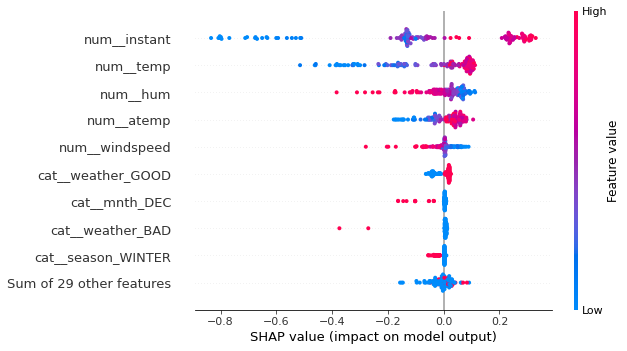

In [12]:
shap.plots.beeswarm(explanation)

In [13]:
if isinstance(explanation.values, list) or len(explanation.values.shape) == 3:
    class_index_to_explain = 1
    shap_values_2d = explanation.values[:, :, class_index_to_explain]
    print(f"분류 문제: {class_index_to_explain}번 클래스에 대한 중요도를 계산합니다.")
else:
    # 회귀 문제일 경우
    shap_values_2d = explanation.values
    print("회귀 문제: 피처 중요도를 계산합니다.")

feature_names = X_test.columns

mean_abs_shap = np.abs(shap_values_2d).mean(axis=0)

feature_importance_df = pd.DataFrame({'feature':feature_names, 'importance':mean_abs_shap})

feature_importance_df

회귀 문제: 피처 중요도를 계산합니다.


,feature,importance
0,num__instant,0.256661
1,num__temp,0.130762
2,num__atemp,0.053720
3,num__hum,0.060002
4,num__windspeed,0.027477
5,num__days_since_2011,0.000000
6,cat__season_FALL,0.009310
7,cat__season_SPRING,0.000131
8,cat__season_SUMMER,0.000000
9,cat__season_WINTER,0.009765


In [14]:
top_n = 9
top_features = feature_importance_df['feature'].head(top_n).tolist()
top_features

['num__instant',
 'num__temp',
 'num__atemp',
 'num__hum',
 'num__windspeed',
 'num__days_since_2011',
 'cat__season_FALL',
 'cat__season_SPRING',
 'cat__season_SUMMER']

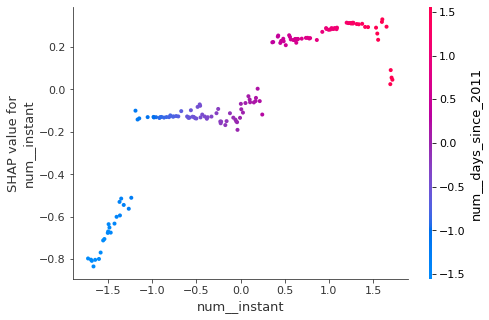

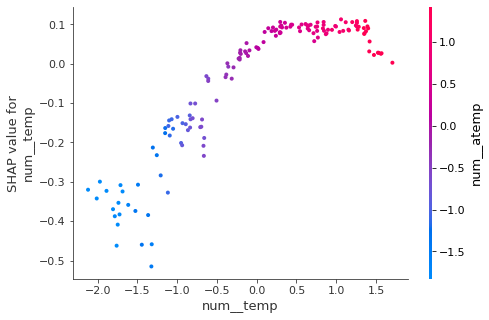

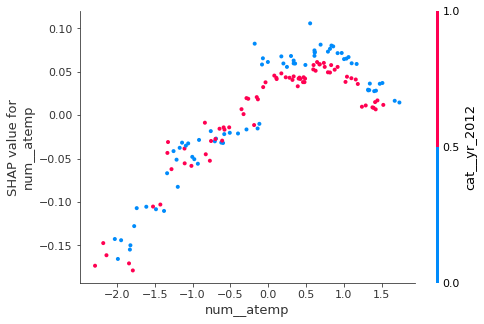

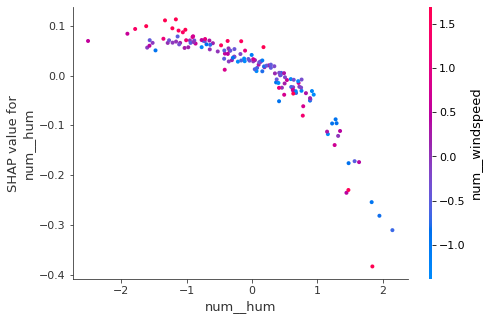

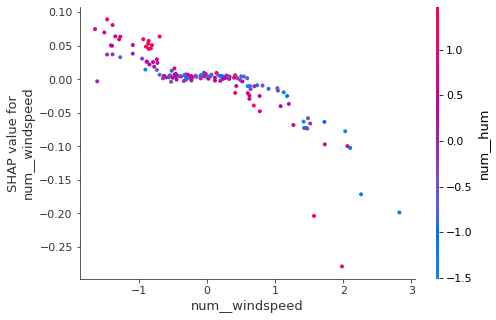

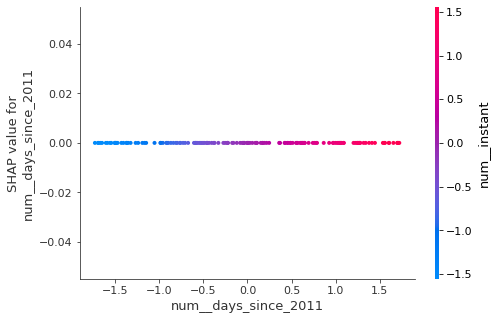

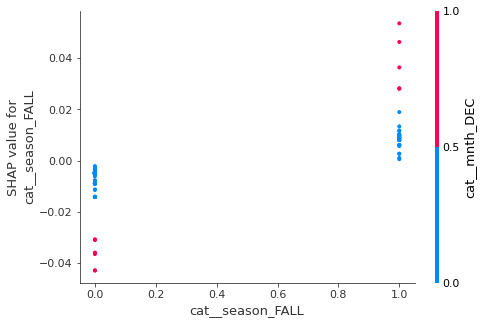

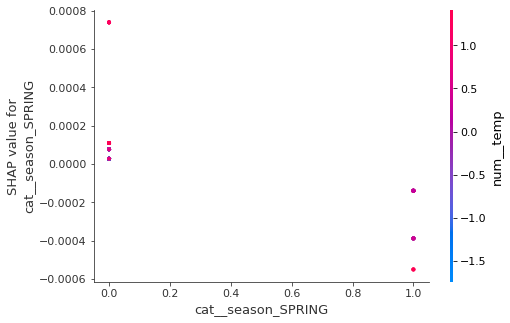

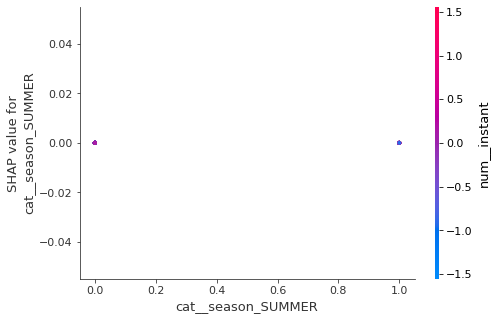

In [15]:
for name in top_features:
    shap.dependence_plot(ind=name, shap_values=explanation.values, features=X_test, interaction_index='auto')

In [51]:
y_train_2, y_test_2 = np.where(y_train > 4000, 1, 0), np.where(y_test > 4000, 1, 0)
y_train_2, y_test_2

(array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 

In [62]:
tf.compat.v1.reset_default_graph()

model2 = XGBClassifier(n_estimators=100, eta=0.2, max_depth=2, random_state=0)
model2.fit(X_train, y_train_2)
model2.score(X_train, y_train_2), model2.score(X_test, y_test_2)

(0.9656357388316151, 0.9041095890410958)

In [73]:
cf_explainer = Counterfactual(model2.predict_proba, shape=(1, X_test.shape[1]), target_class='other', target_proba=0.7, tol=0.05, lam_init=0.01)
cf_explainer.fit(X_train, y_train_2)

Counterfactual(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
)

In [76]:
for i in range(0, 10):
    cf_explanation = cf_explainer.explain(X_test.iloc[[i]].values)
    print(cf_explanation)

No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 1,
  'orig_proba': 0.9952887296676636}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 1,
  'orig_proba': 0.9976961016654968}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 1,
  'orig_proba': 0.9926908612251282}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 1,
  'orig_proba': 0.992060661315918}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 1,
  'orig_proba': 0.9666486382484436}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 1,
  'orig_proba': 0.9301810264587402}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 0,
  'orig_proba': 0.8540622591972351}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 0,
  'orig_proba': 0.9991742968559265}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 0,
  'orig_proba': 0.9992812275886536}
)


No appropriate lambda range found, try decreasing lam_init


Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 38),
              'distance_fn': 'l1',
              'target_proba': 0.7,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.01,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.6'}
, data={
  'cf': None,
  'all': {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []},
  'orig_class': 0,
  'orig_proba': 0.9997565150260925}
)
